In [1]:
# common imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# pandas imports
from pandas.plotting import scatter_matrix

# machine learning imports
from sklearn.model_selection import train_test_split

# display setup
pd.set_option("display.max_columns", None) # the None parameter displays unlimited columns
sns.set(style="whitegrid") # for plots

## 1. Getting the Data

In [2]:
# read the csv file
df = pd.read_csv(r"hotel_bookings.csv")

In [3]:
# display the first 5 rows for a quick look
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [4]:
# DataFrame shape (rows, columns)
# understand the amount of data we are working with
df.shape

(119390, 32)

In [5]:
# description of data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

> In a first observation it is clear that some features have
> missing values (i.e. "company" and "agent" columns).
> We will need to take care of this later.

In [6]:
# summary of the numerical attributes
# null values are ignored
df.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119386.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,103050.000000,6797.000000,119390.000000,119390.000000,119390.000000,119390.000000
mean,0.370416,104.011416,2016.156554,27.165173,15.798241,0.927599,2.500302,1.856403,0.103890,0.007949,0.031912,0.087118,0.137097,0.221124,86.693382,189.266735,2.321149,101.831122,0.062518,0.571363
std,0.482918,106.863097,0.707476,13.605138,8.780829,0.998613,1.908286,0.579261,0.398561,0.097436,0.175767,0.844336,1.497437,0.652306,110.774548,131.655015,17.594721,50.535790,0.245291,0.792798
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,6.000000,0.000000,-6.380000,0.000000,0.000000
25%,0.000000,18.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,62.000000,0.000000,69.290000,0.000000,0.000000
50%,0.000000,69.000000,2016.000000,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,179.000000,0.000000,94.575000,0.000000,0.000000
75%,1.000000,160.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,229.000000,270.000000,0.000000,126.000000,0.000000,1.000000
max,1.000000,737.000000,2017.000000,53.000000,31.000000,19.000000,50.000000,55.000000,10.000000,10.000000,1.000000,26.000000,72.000000,21.000000,535.000000,543.000000,391.000000,5400.000000,8.000000,5.000000


> ### Features in the DataFrame:
>> 1. hotel: Resort Hotel or City Hotel
>> 2. is_canceled: Value indicating if the booking was canceled (1) or not (0)
>> 3. lead_time: Number of days between the booking date to the arrival date
>> 4. arrival_date_year: Year of arrival date
>> 5. arrival_date_month: Month of arrival date
>> 6. arrival_date_week_number: Week number according to year of arrival
>> 7. arrival_date_day_of_month: Day of arrival date
>> 8. stays_in_weekend_nights: Number of weekend nights booked (Saturday or Sunday)
>> 9. stays_in_week_nights: Number of week nights booked (Monday to Friday)
>> 10. adults: Number of adults
>> 11. children: Number of children
>> 12. babies: Number of babies
>> 13. meal: Type of meal booked
>> 14. country: Country of origin
>> 15. market_segment: Market segment designation, typically influences the price sensitivity
>> 16. distribution_channel: Booking distribution channel, refers to how the booking was made
>> 17. is_repeated_guest: Value indication if booking name was from a repeated guest (1) or not (0)
>> 18. previous_cancellations: Number of previous cancellations prior to current booking
>> 19. previous_bookings_not_canceled: Number of previous booking not canceled prior to current booking
>> 20. reserved_room_type: Code of room type reserved
>> 21. assigned_room_type: Code for the type of room assigned to the booking
>> 22. booking_changes: Number of changes made to the booking since entering the hotel management system
>> 23. deposit_type: Type of deposit made for the reservation
>> 24. agent: ID of the travel agency that made the booking
>> 25. company: ID of the company/organization that made the booking or is responsible for payment
>> 26. days_in_waiting_list: Number of days booking was in the waiting list until it was confirmed
>> 27. customer_type: Type of booking
>> 28. adr: Average Daily Rate (the sum of transactions divided by the number of nights stayed)
>> 29. required_car_parking_spaces: Number of car parking spaces requested
>> 30. total_of_special_requests: Number of special requests made by the customer
>> 31. reservation_status: Last reservation status (Canceled, Check-Out, No-Show)
>> 32. reservation_status_date: Date at which the last status was set
>>
>>> ##### *Understanding the features could help gain insight on how to treat null values.*

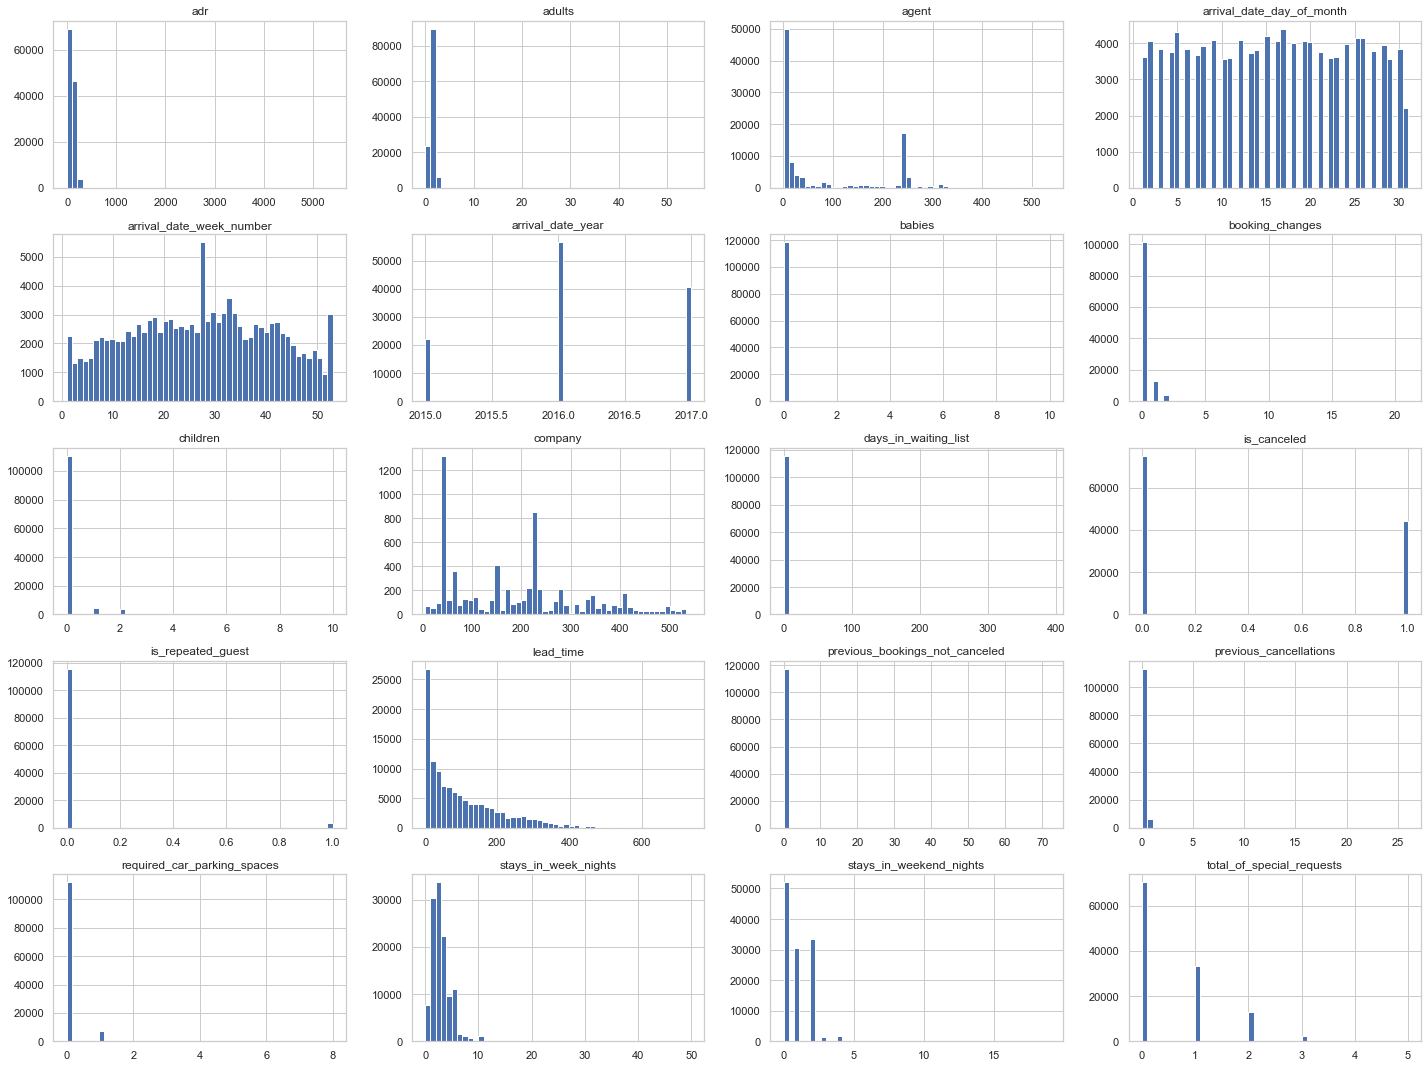

In [7]:
# a histogram plot for each numerical attribute
df.hist(bins=50, figsize=(20,15))
plt.tight_layout()
plt.show()

> Initial observations from the histograms:
>> 1. Some weeks have more bookings. This could be because of holiday or summer seasons, when people tend to travel more.
>> 2. According to the lead_time plot most bookings were made shortly before arrival.
>> 3. Booking tend to be without children or babies.
>> 4. It seems that the most accommodations are two weeks long or shorter.
>> 5. While most bookings were not canceled, there are thousands of instances that were.

> # Objective:
> ## Predicting if a booking will be canceled.
>> ### Chosen Feature:
>> #### *is_canceled* column
>>> 0 means the booking was not canceled
>>>
>>> 1 means the booking was canceled
>> ### Motive:
>> Like any business, hotels are also looking to gain profit. A model that predicts if the booking
>> is likely to be canceled could be a good indication for hotels, as they
>> may prefer to accept the lower risk bookings first.

> ### Missing Features:

In [8]:
# the methods below calculate the number of missing values
missing_values = df.isna().sum()
missing_values = missing_values[missing_values != 0]
missing_values

children         4
country        488
agent        16340
company     112593
dtype: int64

In [9]:
# replace missing values

# can assume that there were no children
df.fillna({"children": 0}, inplace=True)

# missing countries can be labeled unknown
df.fillna({"country": "Unknown"}, inplace=True)

# missing agent ID can be zero, likely booked privately
df.fillna({"agent": 0}, inplace=True)

# missing company ID can be zero, likely personal booking
df.fillna({"company": 0}, inplace=True)

In [10]:
# check that the values were filled
df.isna().sum()

hotel                             0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
deposit_type                      0
agent                             0
company                           0
days_in_waiting_list              0
customer_type                     0
adr                         

> ### Splitting the Data:
>> Before further analysis let's split the data into a training set and a testing set.
>> This will ensure avoidance of bias that could occur from learning the data as a whole.

In [11]:
# use sklearn train_test_split function to split the data
# the reason for selecting 0.15 as the test size is because the dataset is very large
# the random state parameter ensures that data will be shuffled and split the same way in each run
train_set, test_set = train_test_split(df, test_size=0.15, random_state=42)

In [12]:
print("Number of instances in training set: ", len(train_set))
print("Number of instances in testing set: ", len(test_set))

Number of instances in training set:  101481
Number of instances in testing set:  17909


## 2. Understanding and Visualizing the Data
> ##### *The motivation for this section is to gain more insights.*

In [13]:
# deep copy of the training set
df2 = train_set.copy()

In [14]:
df2.head(2)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
24840,Resort Hotel,0,156,2016,May,23,30,1,5,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,241.0,0.0,0,Transient,52.36,0,1,Check-Out,2016-06-05
6904,Resort Hotel,0,292,2016,July,29,10,1,0,2,0.0,0,BB,ISR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,0.0,0,Transient,72.90,1,2,Check-Out,2016-07-11


> ### Numerical Attributes:

In [15]:
# method creates a correlations matrix
corr_matrix = df2.corr()

In [16]:
# looking at attributes correlation with is_canceled feature
corr_matrix["is_canceled"].sort_values(ascending=False)

is_canceled                       1.000000
lead_time                         0.292182
previous_cancellations            0.109883
adults                            0.059744
days_in_waiting_list              0.053068
adr                               0.046790
stays_in_week_nights              0.027764
arrival_date_year                 0.017365
arrival_date_week_number          0.007757
children                          0.006771
stays_in_weekend_nights          -0.000019
arrival_date_day_of_month        -0.006062
babies                           -0.034658
agent                            -0.046444
previous_bookings_not_canceled   -0.055847
company                          -0.082484
is_repeated_guest                -0.084179
booking_changes                  -0.142916
required_car_parking_spaces      -0.195675
total_of_special_requests        -0.233580
Name: is_canceled, dtype: float64

In [17]:
# experimenting with attribute combinations

# adds column with total amount of guests that stayed
df2["guests_stayed"] = df2["adults"] + df2["children"] + df2["babies"]

# adds column with total nights stayed
df2["nights_stayed"] = df2["stays_in_week_nights"] + df2["stays_in_weekend_nights"]

In [18]:
# looking at the correlation matrix again with the added columns
corr_matrix = df2.corr()
corr_matrix["is_canceled"].sort_values(ascending=False)

is_canceled                       1.000000
lead_time                         0.292182
previous_cancellations            0.109883
adults                            0.059744
days_in_waiting_list              0.053068
adr                               0.046790
guests_stayed                     0.046693
stays_in_week_nights              0.027764
nights_stayed                     0.020709
arrival_date_year                 0.017365
arrival_date_week_number          0.007757
children                          0.006771
stays_in_weekend_nights          -0.000019
arrival_date_day_of_month        -0.006062
babies                           -0.034658
agent                            -0.046444
previous_bookings_not_canceled   -0.055847
company                          -0.082484
is_repeated_guest                -0.084179
booking_changes                  -0.142916
required_car_parking_spaces      -0.195675
total_of_special_requests        -0.233580
Name: is_canceled, dtype: float64

> ### Correlations with is_canceled Attribute - Overview:
> The strongest positive correlations (0.1 or more) are:
> * lead_time
> * previous_cancellations
>
> The strongest negative correlations (-0.1 or less) are:
> * total_of_special_requests
> * required_car_parking_spaces
> * booking_changes
>
> The attribute combinations tested (guests stayed and nights stayed) both had weak correlations.

> ### Cancellations According to Lead Time:

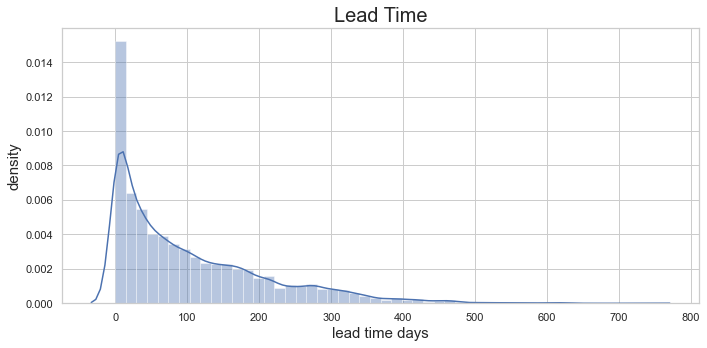

In [19]:
# density plot of lead time
# shows the distribution and highest concentration points
plt.figure(figsize=(10,5))
lead_time = df2['lead_time']
lead_time = pd.DataFrame(sorted(lead_time, reverse = True), columns = ['Lead'])
sns.distplot(lead_time)
plt.title("Lead Time", size=20)
plt.xlabel("lead time days", size=15)
plt.ylabel("density", size=15)
plt.tight_layout()
plt.show()

In [20]:
# divides lead time by less than 100 days, 100-355 days and 365 or more days
lead_time_1 = df2[df2["lead_time"] < 100]
lead_time_2 = df2[(df2["lead_time"] >= 100) & (df2["lead_time"] < 365)]
lead_time_3 = df2[df2["lead_time"] >= 365]

In [21]:
# calculates cancellations according to lead time groups
lead_cancel_1 = lead_time_1["is_canceled"].value_counts()
lead_cancel_2 = lead_time_2["is_canceled"].value_counts()
lead_cancel_3 = lead_time_3["is_canceled"].value_counts()

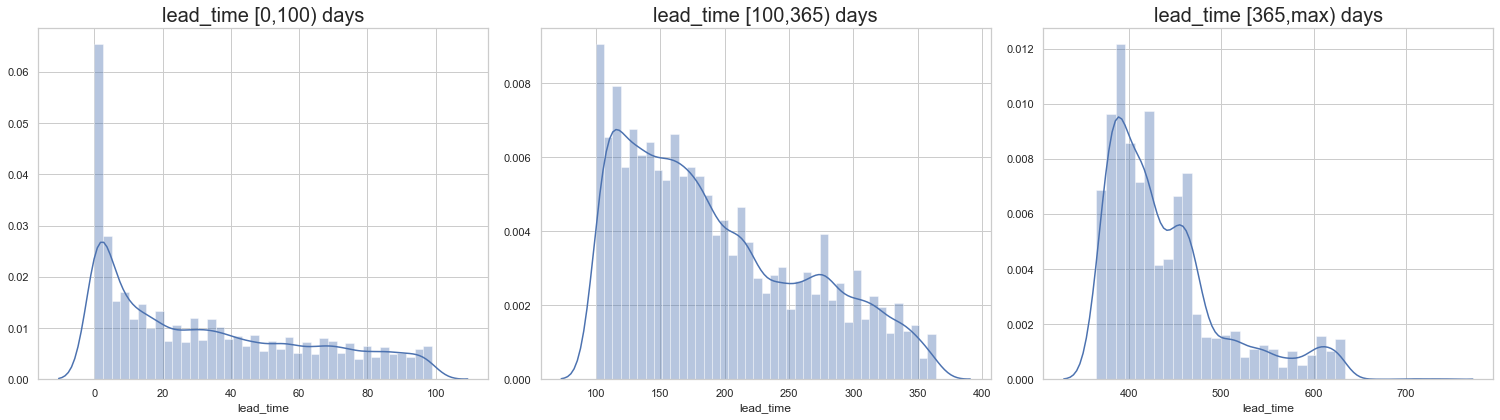

In [22]:
# density plot for each lead time group
fig, bx = plt.subplots(1,3,figsize=(21,6))
sns.distplot(lead_time_1["lead_time"], ax = bx[0])
bx[0].set_title("lead_time [0,100) days", size=20)
sns.distplot(lead_time_2["lead_time"], ax = bx[1])
bx[1].set_title("lead_time [100,365) days", size=20)
sns.distplot(lead_time_3["lead_time"], ax = bx[2])
bx[2].set_title("lead_time [365,max) days", size=20)
plt.tight_layout()
plt.show()

In [23]:
# total count of lead time according to cancellation
total_lead_days_cancel = pd.DataFrame(data=[lead_cancel_1,lead_cancel_2,lead_cancel_3],
             index=["[0,100) days", "[100,365) days", "[365,max) days"])
total_lead_days_cancel

,0,1
"[0,100) days",44163,16828
"[100,365) days",19013,18746
"[365,max) days",873,1858


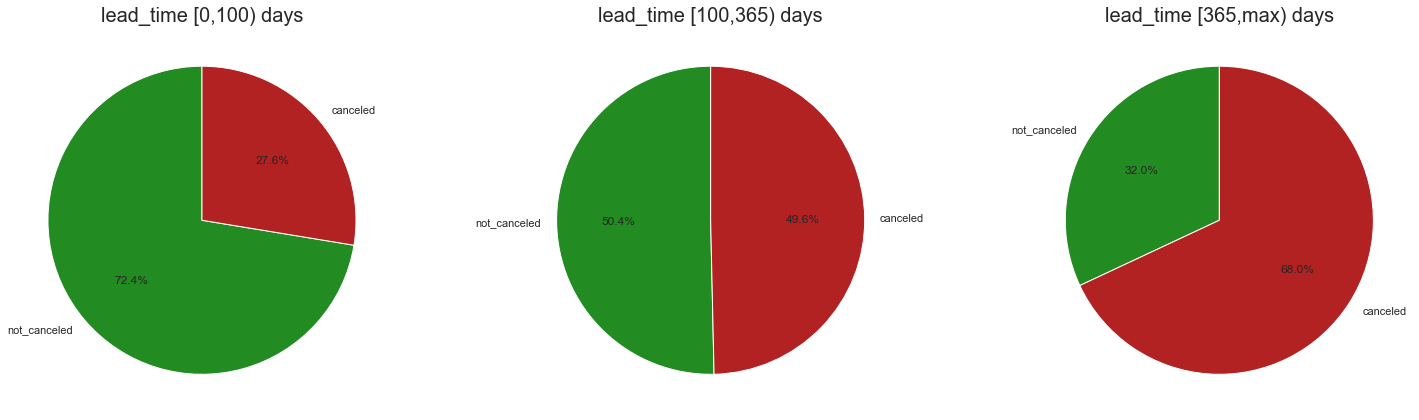

In [24]:
fig, ax = plt.subplots(1,3, figsize=(21,6))
ax[0].pie(np.array([total_lead_days_cancel[0][0], total_lead_days_cancel[1][0]]),
          labels=["not_canceled", "canceled"], autopct='%1.1f%%', startangle=90,
          colors=['forestgreen', 'firebrick'])
ax[0].set_title("lead_time [0,100) days", size=20)
ax[1].pie(np.array([total_lead_days_cancel[0][1], total_lead_days_cancel[1][1]]),
          labels=["not_canceled", "canceled"], autopct='%1.1f%%', startangle=90,
          colors=['forestgreen', 'firebrick'])
ax[1].set_title("lead_time [100,365) days", size=20)
ax[2].pie(np.array([total_lead_days_cancel[0][2], total_lead_days_cancel[1][2]]),
          labels=["not_canceled", "canceled"], autopct='%1.1f%%', startangle=90,
          colors=['forestgreen', 'firebrick'])
ax[2].set_title("lead_time [365,max) days", size=20)
plt.tight_layout()
plt.show()

> #### Observations:
>> * Most bookings occur about 5 days prior to arrival.
>> * When the lead time is larger the chances for cancellation increase.
>> * The amount of bookings is steady overall between 20-100 days, then drops.

> ### Cancellations According to Previous Cancellations:

In [25]:
# gets previous cancellation column
prev_cancel = df2["previous_cancellations"]

In [26]:
# sorts index values
prev_cancel.value_counts().sort_index()

0     96001
1      5112
2       101
3        48
4        29
5        15
6        22
11       30
13        8
14       11
19       17
21        1
24       45
25       20
26       21
Name: previous_cancellations, dtype: int64

In [27]:
print("Cancellation Rates:\n")
print('Never canceled =' ,str(round(df2[df2['previous_cancellations']==0]
                                            ['is_canceled'].mean()*100,2))+' %')
print('Canceled once =' ,str(round(df2[df2['previous_cancellations']==1]
                                            ['is_canceled'].mean()*100,2))+' %')
print('Canceled more than 10 times:',str(round(df2[df2['previous_cancellations']>10]
                                            ['is_canceled'].mean()*100,2))+' %')
print('Canceled more than 11 times:' ,str(round(df2[df2['previous_cancellations']>11]
                                            ['is_canceled'].mean()*100,2))+' %')

Cancellation Rates:

Never canceled = 33.76 %
Canceled once = 94.37 %
Canceled more than 10 times: 85.62 %
Canceled more than 11 times: 99.19 %


In [28]:
# creates a list with previous cancellations indices
prev_cancel_index = df2["previous_cancellations"].value_counts().index.to_list()
# sorts the list
prev_cancel_index.sort()

# calculates the average percentage of cancellations for each value in DataFrame
percentage_prev_cancel= []
for i in prev_cancel_index:
    percentage_prev_cancel.append((round(df2[df2["previous_cancellations"]==i]
                                        ["is_canceled"].mean()*100,2)))
percentage_prev_cancel

[33.76,
 94.37,
 33.66,
 29.17,
 24.14,
 13.33,
 31.82,
 30.0,
 87.5,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0]

In [29]:
# creates a DataFrame with the results
df_prev_cancel = pd.DataFrame(percentage_prev_cancel, index=prev_cancel_index, columns=["Previous Cancellations %"])
df_prev_cancel

,Previous Cancellations %
0,33.76
1,94.37
2,33.66
3,29.17
4,24.14
5,13.33
6,31.82
11,30.00
13,87.50
14,100.00


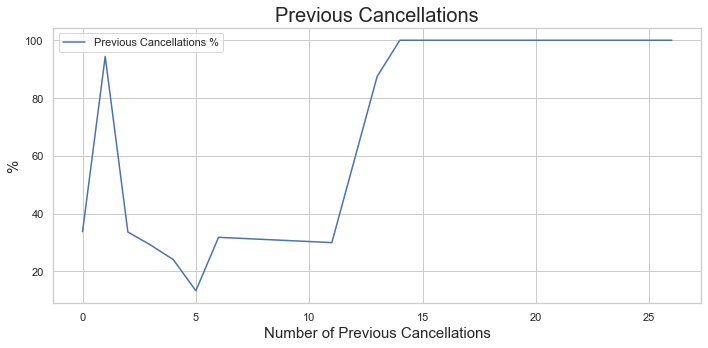

In [30]:
# plots previous cancellations by percentages
df_prev_cancel.plot(figsize= (10,5))
plt.title("Previous Cancellations", size=20)
plt.xlabel("Number of Previous Cancellations", size=15)
plt.ylabel("%", size=15)
plt.tight_layout()
plt.show()

> ### Observations:
>> The percentages show that when there are more previous cancellations, there is
>> a substantially higher chance the customer will cancel again.

> ### Cancellations According to Total of Special Requests:

In [31]:
# number of instances for each value
df2["total_of_special_requests"].value_counts()

0    59677
1    28355
2    11017
3     2120
4      279
5       33
Name: total_of_special_requests, dtype: int64

In [32]:
# group by cancellations
is_canceled = df2.groupby(by="is_canceled")

In [33]:
# get groups according to binary outcomes
canceled = is_canceled.get_group(1)
not_canceled = is_canceled.get_group(0)

In [34]:
# counts values for each outcome
special_requests_0 = not_canceled["total_of_special_requests"].value_counts()
special_requests_1 = canceled["total_of_special_requests"].value_counts()

In [35]:
# creates a DataFrame for each outcome
df_special_requests_0 = pd.DataFrame(special_requests_0.values, index=special_requests_0.index,
                                     columns=["not_canceled"])
df_special_requests_1 = pd.DataFrame(special_requests_1.values, index=special_requests_1.index,
                                     columns=["canceled"])

In [36]:
# joins both DataFrames side by side
df_special_requests= df_special_requests_0.join(df_special_requests_1)

In [37]:
# adds total of both outcomes
special_requests_total = df_special_requests["not_canceled"] + df_special_requests["canceled"]

# calculates percentage of cancellations for each number of requests value individually
special_requests_percentage = []
for i in special_requests_total.index:
    special_requests_percentage.append(round((special_requests_1[i]/special_requests_total[i])*100,2))
special_requests_percentage

[47.53, 21.97, 22.05, 17.88, 10.39, 6.06]

In [38]:
# add percentages as new column in DataFrame
df_special_requests.join(pd.DataFrame(special_requests_percentage, index=df_special_requests.index,
             columns=["cancellations %"]))

,not_canceled,canceled,cancellations %
0,31313,28364,47.53
1,22126,6229,21.97
2,8588,2429,22.05
3,1741,379,17.88
4,250,29,10.39
5,31,2,6.06


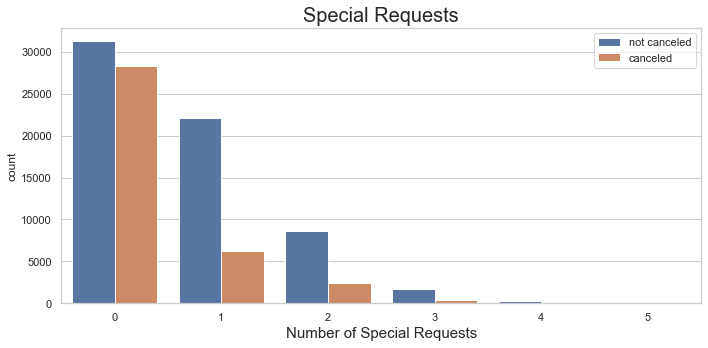

In [39]:
# plots special requests according to cancellations
plt.figure(figsize=(10,5))
sns.countplot(x=df2["total_of_special_requests"], hue=df2["is_canceled"])
plt.title("Special Requests", size=20)
plt.xlabel("Number of Special Requests", size=15)
plt.legend(["not canceled", "canceled"])
plt.tight_layout()
plt.show()

> ### Observations:
>> * Nearly half of the bookings without special requests are canceled.
>> * There are fewer cancellations when the number of special requests increases.

> ### Cancellations According to Required Car Parking Spaces:

In [40]:
df2["required_car_parking_spaces"].value_counts().sort_index()

0    95114
1     6337
2       26
3        2
8        2
Name: required_car_parking_spaces, dtype: int64

In [41]:
# counts values for each outcome
parking_spaces_0 = not_canceled["required_car_parking_spaces"].value_counts()
parking_spaces_1 = canceled["required_car_parking_spaces"].value_counts()

In [42]:
# value counts for non canceled instances
parking_spaces_0

0    57682
1     6337
2       26
8        2
3        2
Name: required_car_parking_spaces, dtype: int64

In [43]:
# value counts for canceled instances
parking_spaces_1

0    37432
Name: required_car_parking_spaces, dtype: int64

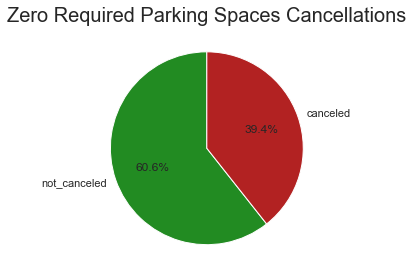

In [44]:
# pie plot of cancellations with zero required parking spaces
plt.pie(x=[parking_spaces_0[0], parking_spaces_1[0]], labels=["not_canceled", "canceled"],
        autopct='%1.1f%%', startangle=90, colors=['forestgreen', 'firebrick'])
plt.title("Zero Required Parking Spaces Cancellations", size=20)
plt.tight_layout()
plt.show()

> ### Observations:
>> * Dividing the instances into groups according to cancellations shows that all canceled
>> bookings were ones without required parking spaces.
>> * This could potentially be a bad indication for cancellations. The model could learn
>> that a booking can be canceled **only** if no parking spaces were required, which does not
>> necessarily have to be the case.

> ### Cancellations According to Booking Changes:

In [45]:
df2["booking_changes"].value_counts().sort_index()

0     86077
1     10809
2      3256
3       793
4       314
5        99
6        60
7        28
8        14
9         6
10        5
11        2
12        2
13        3
14        4
15        3
16        2
17        1
18        1
20        1
21        1
Name: booking_changes, dtype: int64

In [46]:
# counts values for each outcome
booking_changes_0 = not_canceled["booking_changes"].value_counts()
booking_changes_1 = canceled["booking_changes"].value_counts()

In [47]:
# sorts index numbers by value
booking_changes_0.sort_index()

0     51065
1      9272
2      2599
3       668
4       257
5        81
6        43
7        26
8        10
9         6
10        4
11        2
12        2
13        3
14        3
15        3
16        1
17        1
18        1
20        1
21        1
Name: booking_changes, dtype: int64

In [48]:
# sorts index numbers by value
booking_changes_1.sort_index()

0     35012
1      1537
2       657
3       125
4        57
5        18
6        17
7         2
8         4
10        1
14        1
16        1
Name: booking_changes, dtype: int64

In [49]:
df_booking_changes_1 = pd.DataFrame(booking_changes_1, index=booking_changes_0.index)
df_booking_changes_1.fillna({"booking_changes": 0}, inplace=True)
booking_changes_1 = pd.Series(df_booking_changes_1["booking_changes"])

In [50]:
# adds total of both outcomes
booking_changes_total = booking_changes_0 + booking_changes_1

# calculates percentage of cancellations for each number of booking changes individually
percentage_booking_changes = []
for i in booking_changes_total.index:
    percentage_booking_changes.append(round((booking_changes_1[i]/booking_changes_total[i])*100,2))

In [51]:
# create a DataFrame with the percentage of cancellations
df_percentage_booking_changes = pd.DataFrame(percentage_booking_changes, index=booking_changes_total.index,
                                             columns=["cancellations %"])

In [52]:
# creates a DataFrame for each outcome
df_booking_changes_0 = pd.DataFrame(booking_changes_0.values, index=booking_changes_0.index,
             columns=["not_canceled"])
df_booking_changes_1 = pd.DataFrame(booking_changes_1.values, index=booking_changes_1.index,
             columns=["canceled"])

In [53]:
# joins all three DataFrames side by side
df_booking_changes = df_booking_changes_0.join\
    ([df_booking_changes_1, df_percentage_booking_changes])

# remove rows with 0% cancellations
df_booking_changes = df_booking_changes[df_booking_changes["cancellations %"]!=0]
df_booking_changes

,not_canceled,canceled,cancellations %
0,51065,35012.0,40.68
1,9272,1537.0,14.22
2,2599,657.0,20.18
3,668,125.0,15.76
4,257,57.0,18.15
5,81,18.0,18.18
6,43,17.0,28.33
7,26,2.0,7.14
8,10,4.0,28.57
10,4,1.0,20.00


> ### Observations:
>> * While a large amount of bookings with no changes were canceled, this category can change overtime
>> which could possibly be a source of leakage.

> ### Categorical Attributes:

> ### Cancellations According to Hotels and Arrival Month

In [54]:
df2["hotel"].value_counts()

City Hotel      67539
Resort Hotel    33942
Name: hotel, dtype: int64

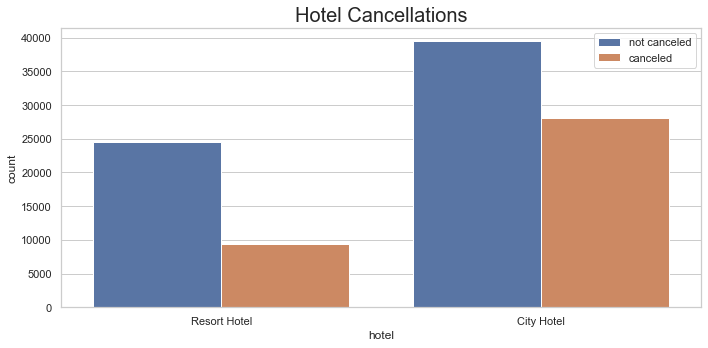

In [55]:
# a plot of the number of instances for each hotel according to cancellations
plt.figure(figsize=(10,5))
sns.countplot(x=df2["hotel"], hue=df2["is_canceled"])
plt.title("Hotel Cancellations", size=20)
plt.legend(["not canceled", "canceled"])
plt.tight_layout()
plt.show()

In [56]:
ordered_months = ["January", "February", "March", "April", "May", "June",
          "July", "August", "September", "October", "November", "December"]

resort_canceled_percent = []
city_canceled_percent = []

# dividing cancellation outcome by hotel and month of arrival
resort_1 = canceled[canceled["hotel"]=="Resort Hotel"]["arrival_date_month"].value_counts()
resort_0 = not_canceled[not_canceled["hotel"]=="Resort Hotel"]["arrival_date_month"].value_counts()
city_1 = canceled[canceled["hotel"]=="City Hotel"]["arrival_date_month"].value_counts()
city_0 = not_canceled[not_canceled["hotel"]=="City Hotel"]["arrival_date_month"].value_counts()

# calculating cancellation percentage according to hotel
for i in ordered_months:
    resort_canceled_percent.append(round((resort_1[i] / (resort_0[i]+resort_1[i]))*100,2))
    city_canceled_percent.append(round((city_1[i]/(city_0[i]+city_1[i]))*100,2))

# creates a DataFrame with the cancellation percentage of each hotel
df_resort_cancel = pd.DataFrame(resort_canceled_percent, index=ordered_months,
                                       columns=["Resort Hotel Canceled %"])
df_city_cancel = pd.DataFrame(city_canceled_percent, index=ordered_months,
                                       columns=["City Hotel Canceled %"])

# joins DataFrames
df_hotel_cancel = df_resort_cancel.join(df_city_cancel)
df_hotel_cancel

,Resort Hotel Canceled %,City Hotel Canceled %
January,15.33,39.29
February,25.10,38.22
March,22.89,36.82
April,29.35,46.17
May,28.83,44.26
June,32.95,44.37
July,31.03,40.63
August,33.33,39.78
September,32.13,42.06
October,27.20,42.82


> ### Observations:
>> * There are more instances for City Hotel than Resort Hotel in the data.
>> * City Hotel has a higher cancellation rate according to arrival months.

> ### Cancellations According to Meal Booked

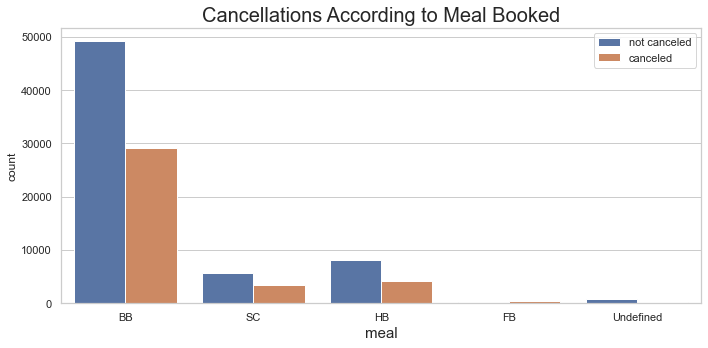

In [57]:
# plots meal according to cancellations
plt.figure(figsize=(10,5))
sns.countplot(x=df2["meal"], hue=df2["is_canceled"])
plt.title("Cancellations According to Meal Booked", size=20)
plt.xlabel("meal", size=15)
plt.legend(["not canceled", "canceled"])
plt.tight_layout()
plt.show()

> ### Observations:
>> * The BB (Bed & Breakfast) meal is most common. It is also most frequently canceled.

> ### Cancellations According to Market Segment, Distribution Channel, Customer Type and Room Type

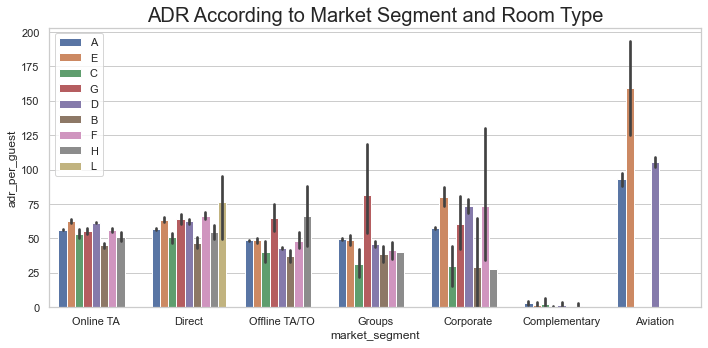

In [58]:
# using groupby to show onl non canceled instances
reserved_room_1 = not_canceled[["reserved_room_type", "market_segment", "customer_type",
                            "distribution_channel", "adr", "guests_stayed"]]

# remove instances without guests
reserved_room_1 = reserved_room_1.loc[(reserved_room_1["guests_stayed"]>0)]
# calculate average adr per guest
# dividing adr by guests stayed
reserved_room_1["adr_per_guest"] = reserved_room_1["adr"] / reserved_room_1["guests_stayed"]

# plot of adr according to market segment and room type
plt.figure(figsize=(10,5))
sns.barplot(x=reserved_room_1["market_segment"], y= reserved_room_1["adr_per_guest"],
            hue=reserved_room_1["reserved_room_type"])
plt.title("ADR According to Market Segment and Room Type", size=20)
plt.legend(loc=2)
plt.tight_layout()
plt.show()

In [59]:
df2["market_segment"].value_counts()

Online TA        48113
Offline TA/TO    20585
Groups           16769
Direct           10689
Corporate         4485
Complementary      639
Aviation           199
Undefined            2
Name: market_segment, dtype: int64

In [60]:
# calculate cancellation percentage according to market segment
market_segment_percent = []

market_segment_1 = canceled["market_segment"].value_counts()
market_segment_total = df2["market_segment"].value_counts()

for i in market_segment_total.index:
    market_segment_percent.append(str(i+": ") +
                    str(round((market_segment_1[i]/market_segment_total[i])*100,2)))
market_segment_percent

['Online TA: 36.57',
 'Offline TA/TO: 34.19',
 'Groups: 60.65',
 'Direct: 15.51',
 'Corporate: 18.71',
 'Complementary: 13.15',
 'Aviation: 22.11',
 'Undefined: 100.0']

In [61]:
df2["distribution_channel"].value_counts()

TA/TO        83251
Direct       12412
Corporate     5652
GDS            161
Undefined        5
Name: distribution_channel, dtype: int64

In [62]:
# calculate cancellation percentage according to distribution channel
distribution_channel_percent = []

distribution_channel_1 = canceled["distribution_channel"].value_counts()
distribution_channel_total = df2["distribution_channel"].value_counts()

for i in distribution_channel_total.index:
    distribution_channel_percent.append(str(i+": ") +
                    str(round((distribution_channel_1[i]/distribution_channel_total[i])*100,2)))
distribution_channel_percent

['TA/TO: 40.81',
 'Direct: 17.6',
 'Corporate: 21.89',
 'GDS: 19.88',
 'Undefined: 80.0']

In [63]:
df2["customer_type"].value_counts()

Transient          76111
Transient-Party    21426
Contract            3448
Group                496
Name: customer_type, dtype: int64

In [64]:
# calculate cancellation percentage according to customer type
customer_type_percent = []

customer_type_1 = canceled["customer_type"].value_counts()
customer_type_total = df2["customer_type"].value_counts()

for i in customer_type_total.index:
    customer_type_percent.append(str(i+": ") +
                    str(round((customer_type_1[i]/customer_type_total[i])*100,2)))
customer_type_percent

['Transient: 40.6', 'Transient-Party: 25.28', 'Contract: 31.0', 'Group: 9.48']

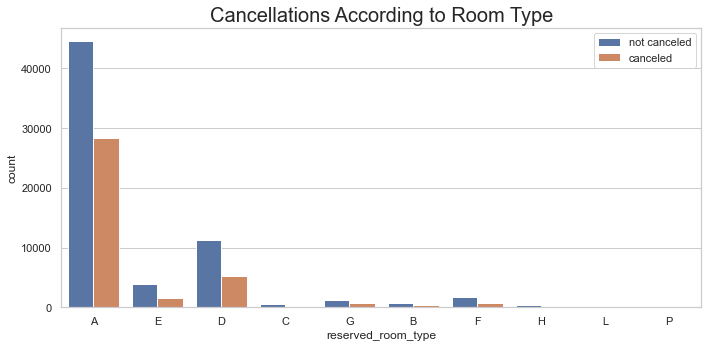

In [65]:
# plot of cancellations according to room type
plt.figure(figsize=(10,5))
sns.countplot(x=df2["reserved_room_type"], hue=df2["is_canceled"])
plt.title("Cancellations According to Room Type", size=20)
plt.legend(["not canceled", "canceled"], loc=1)
plt.tight_layout()
plt.show()

> ### Observations:
>> * Aviation (airline staff) have the highest adr (relative cost of a room when the booking would be made for).
>> * Market segment cancellation rates are highest amongst travel agencies and tour operators.
>> * Distribution channel cancellation rates are highest amongst groups, travel agencies and tour operators.
>> * Customer type cancellation rates are highest amongst transient
>> (meaning the booking is not part of a group or contract and is not associated to another transient booking).
>> * The room type "A" is canceled most frequently.

> ### Cancellations According to Deposit Type

In [66]:
df2["deposit_type"].value_counts()

No Deposit    89037
Non Refund    12304
Refundable      140
Name: deposit_type, dtype: int64

In [67]:
# calculate deposit type instances percentage in data
deposit_percent = round(df2["deposit_type"].value_counts()/len(df["deposit_type"])*100,4)
deposit_percent

No Deposit    74.5766
Non Refund    10.3057
Refundable     0.1173
Name: deposit_type, dtype: float64

In [68]:
# using groupby to divide according to deposit types
deposit = df2.groupby(by="deposit_type")
non_refund = deposit.get_group("Non Refund")
refundable = deposit.get_group("Refundable")
no_deposit = deposit.get_group("No Deposit")

In [69]:
# calculate number of cancellations according to deposit type
no_deposit_0 = (no_deposit["is_canceled"]==0).sum()
no_deposit_1 = (no_deposit["is_canceled"]==1).sum()
non_refund_0 = (non_refund["is_canceled"]==0).sum()
non_refund_1 = (non_refund["is_canceled"]==1).sum()
refundable_0 = (refundable["is_canceled"]==0).sum()
refundable_1 = (refundable["is_canceled"]==1).sum()
all_canceled = no_deposit_1 + non_refund_1 + refundable_1
all_not_canceled = no_deposit_0 + non_refund_0 + refundable_0

In [70]:
# check that all values were calculated
all_canceled + all_not_canceled == df2["deposit_type"].size

True

In [71]:
# create a DataFrame with the number of instances for each deposit type
df_deposit_type = pd.DataFrame(index=["Not Canceled", "Canceled"])
df_deposit_type["no_deposit"] = [no_deposit_0, no_deposit_1]
df_deposit_type["non_refund"] = [non_refund_0, non_refund_1]
df_deposit_type["refundable"] = [refundable_0, refundable_1]
df_deposit_type

,no_deposit,non_refund,refundable
Not Canceled,63860,81,108
Canceled,25177,12223,32


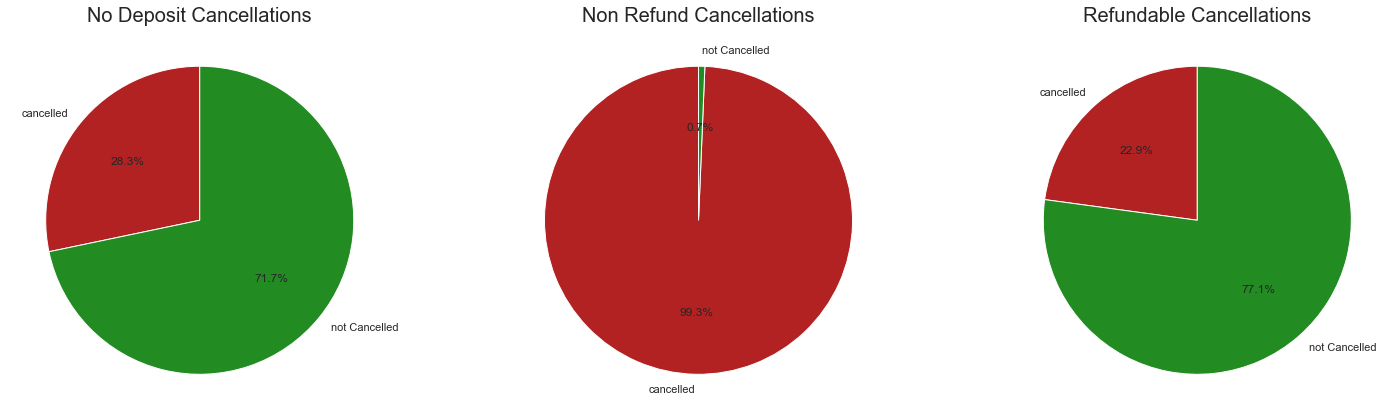

In [79]:
cancel_labels = ["cancelled", "not Cancelled"]
fig, dx = plt.subplots(1,3, figsize=(21,6))
dx[0].pie(np.array([no_deposit_1, no_deposit_0]), labels=cancel_labels,
            autopct='%1.1f%%', startangle=90, colors=['firebrick', 'forestgreen'])
dx[0].set_title("No Deposit Cancellations", size=20)
dx[1].pie(np.array([non_refund_1, non_refund_0]), labels=cancel_labels,
            autopct='%1.1f%%', startangle=90, colors=['firebrick', 'forestgreen'])
dx[1].set_title("Non Refund Cancellations", size=20)
dx[2].pie(np.array([refundable_1, refundable_0]), labels=cancel_labels,
            autopct='%1.1f%%', startangle=90, colors=['firebrick', 'forestgreen'])
dx[2].set_title("Refundable Cancellations", size=20)
plt.tight_layout()
plt.show()